#**DATA 612 Project 1 | Global Baseline Predictors and RMSE**

**Name:** Umais Siddiqui

**Class:** Data 612 - Recommender Systems

**Github Link:** https://github.com/umais/DATA612_Recommender_Systems/blob/master/Week1/Week1_Project1.ipynb



#**Introduction**

In this assignment I will be attempting to create a basic reccommender system and make the recommender be able to predict hotels for users. For the data I have downloaded the **data.csv** from Huggingface for the trip advisor hotel reviews.

**Reference:**

Niimi, Jun. *Tripadvisor Review Rating Dataset*. Hugging Face, https://huggingface.co/datasets/jniimi/tripadvisor-review-rating.





#**Approach**

My approach to building the global baseline predictor model for the predictions of hotel ratings from Trip Advisor data. I will be performing the following steps:

- Read the file using Python Pandas package and load it in to a Dataframe.

- Do some basic analysis on the data find out number of unique users and hotels.

- Determine the N/A ratings and exclude them from the calculations.

- Split the data set in to training and test data set using the sklearn.model.selection package in python and utiilize the train_test_split function
- Calculate the Global Average of the Ratings
- Calculate the counts and sum of ratings for users and the hotels
- Calculate the user and hotels bias (error)
- Define L2 Regularization Parameter (λ)
- Apply the predictions to the Train and Test Data Sets
- Calculate the RMSE and MAE
- Conclusion

#**Load Data**

In the code below I am using pandas to load the data in tot a data frame called "df" using the info method to display some basic statistics . Also getting some basic counts on the number of unique user, hotels , users who have rated multiple hotels as well as rating distribution.

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201295 entries, 0 to 201294
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     201295 non-null  int64  
 1   hotel_id       201295 non-null  int64  
 2   user_id        201295 non-null  object 
 3   title          201292 non-null  object 
 4   text           201295 non-null  object 
 5   overall        201295 non-null  float64
 6   cleanliness    201295 non-null  float64
 7   value          201295 non-null  float64
 8   location       201295 non-null  float64
 9   rooms          201295 non-null  float64
 10  sleep_quality  201295 non-null  float64
 11  stay_year      201295 non-null  int64  
 12  post_date      201295 non-null  object 
 13  freq           201295 non-null  int64  
 14  review         201295 non-null  object 
 15  char           201295 non-null  int64  
 16  lang           201295 non-null  object 
dtypes: float64(6)

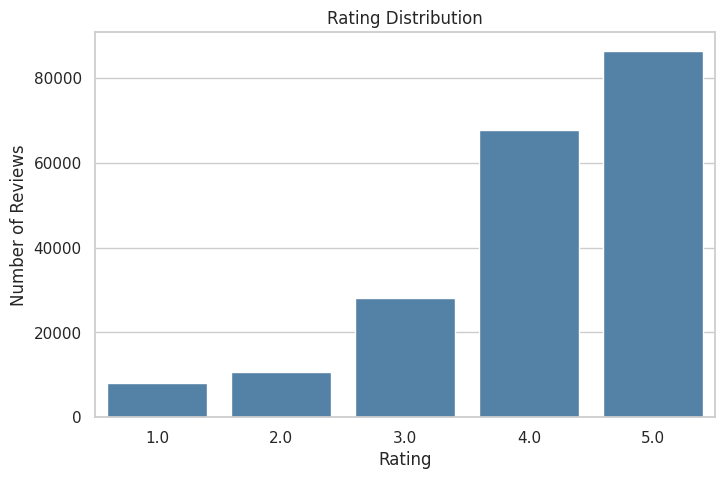

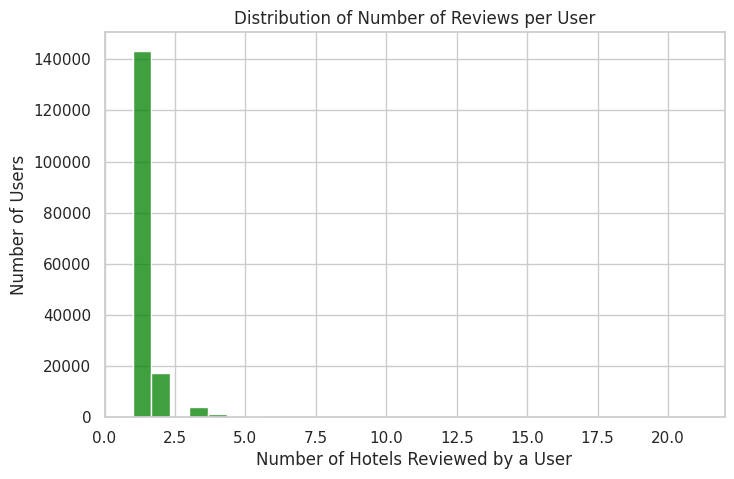

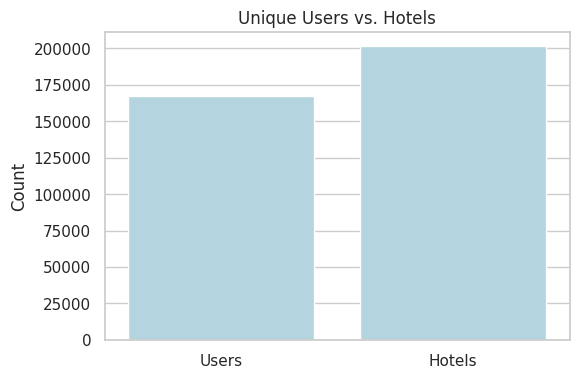

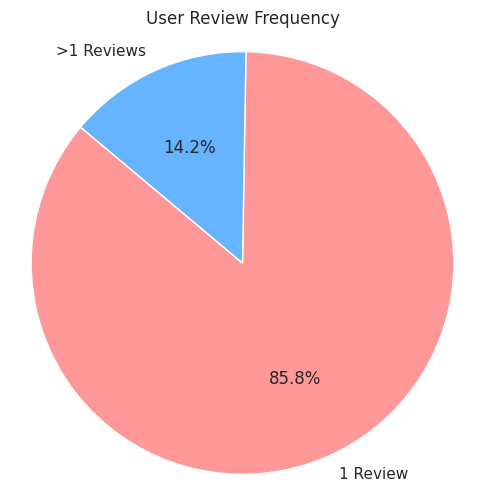

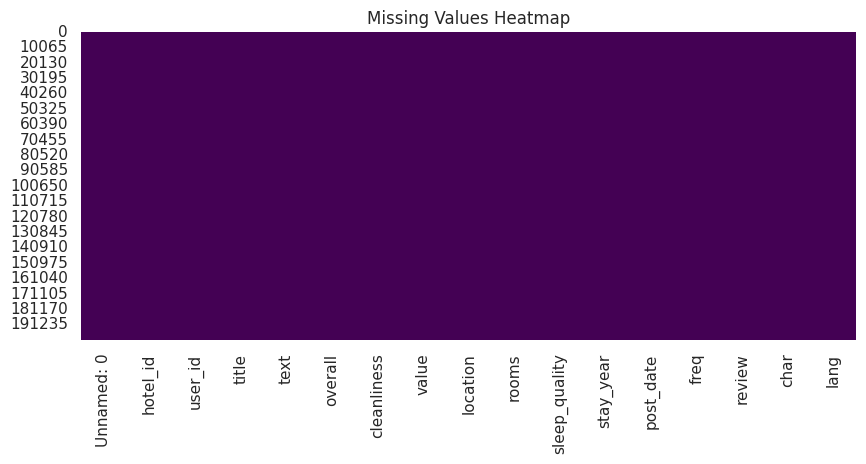

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Load dataset from local CSV file
df = pd.read_csv('data.csv')

# Display basic info
print("DataFrame Info:")
print(df.info())

# Display column names
print("\n Columns:")
print(df.columns.tolist())

# Display first few rows
print("\n Data Preview:")
print(df.head())

# Basic descriptive statistics
print("\n Descriptive Statistics:")
print(df.describe(include='all'))

# Number of unique users and hotels
if 'user_id' in df.columns and 'hotel_id' in df.columns:
    print("\n Unique Users:", df['user_id'].nunique())
    print(" Unique Hotels:", df['hotel_id'].nunique())

# Ratings distribution
if 'overall' in df.columns:
    print("\n Rating Distribution:")
    print(df['overall'].value_counts().sort_index())

# Check if users rated multiple hotels
if 'user_id' in df.columns:
    user_review_counts = df['user_id'].value_counts()
    multi_review_users = (user_review_counts > 1).sum()
    print(f"\n Users who reviewed more than one hotel: {multi_review_users}")

# Count NaN values in 'overall' (ratings) column
missing_ratings = df['overall'].isna().sum()
print(f"Number of missing (NaN) ratings: {missing_ratings}")

%matplotlib inline

# Set a consistent theme
sns.set(style="whitegrid")

# 1. Bar chart for rating distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='overall', data=df, color='steelblue')  # use color instead of palette
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.show()

# 2. Histogram of number of reviews per user
user_review_counts = df['user_id'].value_counts()

plt.figure(figsize=(8, 5))
sns.histplot(user_review_counts, bins=30, kde=False, color='green')  # already uses color, good
plt.title("Distribution of Number of Reviews per User")
plt.xlabel("Number of Hotels Reviewed by a User")
plt.ylabel("Number of Users")
plt.show()

# 3. Bar chart showing number of unique users and hotels
unique_users = df['user_id'].nunique()
unique_hotels = df['hotel_id'].nunique()

plt.figure(figsize=(6, 4))
sns.barplot(x=['Users', 'Hotels'], y=[unique_users, unique_hotels], color='lightblue')  # use color, remove palette
plt.title("Unique Users vs. Hotels")
plt.ylabel("Count")
plt.show()

# 4. Pie chart of users who reviewed only 1 hotel vs more than 1
single_review = (user_review_counts == 1).sum()
multi_review = (user_review_counts > 1).sum()

plt.figure(figsize=(6, 6))
plt.pie([single_review, multi_review],
        labels=['1 Review', '>1 Reviews'],
        autopct='%1.1f%%',
        colors=['#ff9999','#66b3ff'],
        startangle=140)
plt.title("User Review Frequency")
plt.axis('equal')
plt.show()

# Visualize missing values with a heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()



#**Data Observations**

Here are some key points that we can see in the data

- There are no missing or N/A ratings so the data has users that have rated at least one hotel

- There are more unique hotels then users

- There are more 5 star ratings than other ratings.

- Approximately 86% of the users only rated 1 hotel.

Now we will split the dataset in to train and test

#**Split Hotel Ratings Data in to Training and Test Dataset**

So below we are basically splitting the data set in to a training and test sub set . The training data will comprise of 80% of the original data where as the test data will be 20% of the original. We will then calculate the Global Average Rating from the training data.



In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
# Keep only relevant columns for simplicity
df = df[['user_id', 'hotel_id', 'overall']]

# Remove missing values (if any)
df = df.dropna(subset=['user_id', 'hotel_id', 'overall'])

# Split into train and test (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Global average rating
global_avg = train_df['overall'].mean()
print(f"Global average rating: {global_avg:.4f}")


Global average rating: 4.0613


#**Adding bias and creating the Model**

**User bias (b_u)** refers to the tendency of some users to consistently rate items higher or lower than the average. For example, some users may generally give higher ratings regardless of the item, while others might be more critical and give lower ratings overall.

**Item bias (b_i)** refers to the tendency of some items (hotels) to receive ratings that are systematically higher or lower than the average. For instance, a very popular hotel might generally get higher ratings, while a less favored hotel might get lower ratings on average.

Both biases help improve rating predictions by capturing these consistent deviations from the global average rating.


The predicted rating is calculated as:

$$
\hat{r}_{ui} = \mu + b_u + b_i
$$

Where:

- \( \hat{r}_{ui} \) is the predicted rating for user \( u \) and item \( i \)  
- \( \mu \) is the global average rating  
- \( b_u \) is the bias of user \( u \)  
- \( b_i \) is the bias of item \( i \)


In [5]:

# Compute user bias b_u = avg rating by user - global_avg
user_bias = train_df.groupby('user_id')['overall'].mean() - global_avg
user_bias = user_bias.to_dict()

# Compute item bias b_i = avg rating by hotel - global_avg
item_bias = train_df.groupby('hotel_id')['overall'].mean() - global_avg
item_bias = item_bias.to_dict()

# Function to predict rating using baseline predictor
def predict(row):
    u = row['user_id']
    i = row['hotel_id']
    bu = user_bias.get(u, 0)
    bi = item_bias.get(i, 0)
    return global_avg + bu + bi

# Apply prediction on train and test sets
train_df['predicted'] = train_df.apply(predict, axis=1)
test_df['predicted'] = test_df.apply(predict, axis=1)



Now we have the predict function defined and both training and test data sets trained.




#**Compute MAE and RMSE**

 Now I am ready to compute the MAE and RMSE for the Model.



The **Mean Absolute Error (MAE)** is defined as:

MAE measures the average magnitude of the errors between predicted and actual ratings, without considering their direction.

$$
MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$


- Lower MAE means more accurate predictions.
- It treats all errors equally.


The **Root Mean Squared Error (RMSE)** is defined as:

RMSE measures the square root of the average of squared differences between predicted and actual ratings.

$$
RMSE = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 }
$$

- Lower RMSE indicates better model performance.
- Penalizes large errors more than MAE.

Where:  
- \( y_i \) is the actual value  
- \( \hat{y}_i \) is the predicted value  
- \( n \) is the number of samples

In [6]:
# Compute RMSE
train_rmse = np.sqrt(mean_squared_error(train_df['overall'], train_df['predicted']))
test_rmse = np.sqrt(mean_squared_error(test_df['overall'], test_df['predicted']))

train_mae = mean_absolute_error(train_df['overall'], train_df['predicted'])
test_mae = mean_absolute_error(test_df['overall'], test_df['predicted'])

print(f"Train MAE : {train_mae:.4f}")
print(f"Test MAE : {test_mae:.4f}")

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Train MAE : 0.7563
Test MAE : 0.8500
Train RMSE: 1.0079
Test RMSE: 1.1377


- The **MAE** values indicate that on average, the predicted ratings differ from the actual ratings by about 0.76 on the training data and 0.85 on the test data.
- The **RMSE** values are slightly higher than MAE, showing the model has some larger errors as RMSE penalizes big errors more.
- The test errors (MAE and RMSE) are higher than training errors, which is typical and suggests the model generalizes reasonably well but with some error increase on unseen data.
- Overall, these errors suggest moderate prediction accuracy but there is room for improvement.

#**Improving the Model by using Regularization Parameter**

### Regularized Baseline Recommender System

This code below implements a **regularized baseline recommender system** that uses global averages and user/item-specific biases to predict hotel ratings. Below is a step-by-step summary of the code:

---

#### 1. Regularization Parameter
- A regularization value `λ = 9` is defined to prevent overfitting when computing biases for users or hotels with fewer ratings.

#### 2. Global Average Rating
- The **global average** (`μ`) of all training ratings is calculated to serve as the baseline rating.

#### 3. User and Item Bias Calculation
- The user bias `b_u` and item bias `b_i` are computed with regularization:
  
  $$
  b_u = \frac{\sum r_u - N_u \cdot \mu}{N_u + \lambda}, \quad
  b_i = \frac{\sum r_i - N_i \cdot \mu}{N_i + \lambda}
  $$
  
  - \( \sum r_u \): sum of ratings given by user
  - \( \sum r_i \): sum of ratings received by item
  - \( N_u, N_i \): number of ratings per user/item
  - \( \mu \): global average

#### 4. Prediction Formula
- For each user–item pair, the predicted rating is:
  
  $$
  \hat{r}_{ui} = \mu + b_u + b_i
  $$

#### 5. Applying the Prediction
- The prediction formula is applied to both the **training** and **testing** datasets.

#### 6. Evaluation
- The system is evaluated using:
  - **RMSE (Root Mean Squared Error)**: penalizes large errors.
  - **MAE (Mean Absolute Error)**: average absolute difference between true and predicted ratings.

#### 7. Output
- The code prints the following for both training and testing:
  - `Train MAE with regularization`
  - `Test MAE with regularization`
  - `Train RMSE with regularization`
  - `Test RMSE with regularization`

---

This baseline model is a strong foundation before incorporating more advanced techniques like Matrix Factorization or Neural Collaborative Filtering.


In [ ]:


# Regularization parameter (tune this)
lambda_reg =9

# Calculate global average again on train data
global_avg = train_df['overall'].mean()

# Calculate user bias with regularization
user_counts = train_df.groupby('user_id').size()
user_sum = train_df.groupby('user_id')['overall'].sum()
user_bias = ((user_sum - user_counts * global_avg) / (user_counts + lambda_reg)).to_dict()

# Calculate item bias with regularization
item_counts = train_df.groupby('hotel_id').size()
item_sum = train_df.groupby('hotel_id')['overall'].sum()
item_bias = ((item_sum - item_counts * global_avg) / (item_counts + lambda_reg)).to_dict()

# Prediction function remains same
def predict_regularized(row):
    u = row['user_id']
    i = row['hotel_id']
    bu = user_bias.get(u, 0)
    bi = item_bias.get(i, 0)
    return global_avg + bu + bi

train_df['predicted_reg'] = train_df.apply(predict_regularized, axis=1)
test_df['predicted_reg'] = test_df.apply(predict_regularized, axis=1)

train_rmse_reg = np.sqrt(mean_squared_error(train_df['overall'], train_df['predicted_reg']))
test_rmse_reg = np.sqrt(mean_squared_error(test_df['overall'], test_df['predicted_reg']))

train_mae_reg = mean_absolute_error(train_df['overall'], train_df['predicted_reg'])
test_mae_reg = mean_absolute_error(test_df['overall'], test_df['predicted_reg'])

print(f"Train MAE with regularization: {train_mae_reg:.4f}")
print(f"Test MAE with regularization: {test_mae_reg:.4f}")

print(f"Train RMSE with regularization: {train_rmse_reg:.4f}")
print(f"Test RMSE with regularization: {test_rmse_reg:.4f}")


Train MAE with regularization: 0.6489
Test MAE with regularization: 0.8066
Train RMSE with regularization: 0.8571
Test RMSE with regularization: 1.0629


### **Results Summary: Regularized Baseline Recommender System**

After implementing a regularized baseline recommender system using a regularization parameter **λ = 9**, the model was evaluated using **Mean Absolute Error (MAE)** and **Root Mean Squared Error (RMSE)**. Below are the performance metrics:

#### Training Performance
- **Train MAE**: 0.6489  
- **Train RMSE**: 0.8571  

These indicate that, on average, the model's predicted ratings are off by about **0.65 stars**, with larger errors penalized in the RMSE metric.

#### Testing Performance
- **Test MAE**: 0.8066  
- **Test RMSE**: 1.0629  

The testing error is slightly higher, which is expected due to generalization to unseen data. An RMSE slightly above 1 suggests that most predictions are within ~1 star of the actual rating.

---

#### Interpretation
- The **low training error** suggests the model fits the training data well.
- The **test error being only moderately higher** indicates the model generalizes reasonably well without overfitting.
- This regularized baseline can serve as a **strong benchmark** before trying more complex models like matrix factorization or deep learning-based recommenders.





### **Result Comparison**

This section compares the performance of the baseline recommender **with and without regularization**. The goal is to understand the effect of bias regularization on prediction accuracy.

---

#### Without Regularization

- **Train MAE**: 0.7563  
- **Test MAE**: 0.8500  
- **Train RMSE**: 1.0079  
- **Test RMSE**: 1.1377  

 **Interpretation**:  
Without regularization, the model tends to overfit the training data slightly, leading to higher errors on unseen test data. The errors suggest that predictions are off by ~0.75 to 1.1 stars on average.

---

#### With Regularization (λ = 9)

- **Train MAE**: 0.6489  
- **Test MAE**: 0.8066  
- **Train RMSE**: 0.8571  
- **Test RMSE**: 1.0629  

 **Interpretation**:  
Introducing regularization reduces both training and test errors, indicating improved generalization. Predictions are now closer to true ratings, especially on the training data, while test error is also lower compared to the non-regularized version.

---



### **Analyzing Predictions for Top 5 Most Active Users**

In [ ]:
# 1. Find top 5 users by number of reviews
top_users = train_df['user_id'].value_counts().head(5).index.tolist()

# 2. Filter test data for only those users
top_users_test = test_df[test_df['user_id'].isin(top_users)].copy()

# 3. Add prediction column if not already present
if 'predicted_reg' not in top_users_test.columns:
    top_users_test['predicted_reg'] = top_users_test.apply(predict_regularized, axis=1)

# 4. Show actual vs predicted for top users
for user in top_users:
    print(f"\n--- Predictions for User ID: {user} ---")
    user_data = top_users_test[top_users_test['user_id'] == user]
    print(user_data[['hotel_id', 'overall', 'predicted_reg']])



--- Predictions for User ID: CATID_ ---
         hotel_id  overall  predicted_reg
15192   124071675      3.0       3.872278
188541  131065878      4.0       3.872278

--- Predictions for User ID: 864564BFFEAF531642321DC1DD6EAA71 ---
         hotel_id  overall  predicted_reg
134340  128357552      4.0       4.290442
90789   128357331      4.0       4.290442
95391   143993860      5.0       4.290442
180675  143874421      5.0       4.290442

--- Predictions for User ID: 28EFD087B8A72D75814F2E2BD6E9326F ---
        hotel_id  overall  predicted_reg
46735  147701353      3.0       3.814646
36714  146041765      4.0       3.814646

--- Predictions for User ID: 083396DAD4EE68B85FA7E4AEC7B8B65A ---
        hotel_id  overall  predicted_reg
18801  126280809      3.0       3.888705
90529  139590106      4.0       3.888705

--- Predictions for User ID: 362E042EFEAB26968583D43D00527B56 ---
         hotel_id  overall  predicted_reg
125126  143400447      3.0       4.070523
92833   131165617      4.

# **Conclusion:**

Regularization improves model stability by preventing overfitting and smoothing extreme biases in users and items. It leads to **lower MAE and RMSE**, especially in the training set, and gives **slightly more accurate predictions on unseen data**.

The predictions for the top 5 most active users show that the regularized baseline predictor provides reasonably close estimates to the actual ratings, typically within ±1 rating point. For example:

User CATID_ rated hotels 3 and 4, while predictions were ~3.87 — slightly optimistic, but close.

User 864564BFFEAF531642321DC1DD6EAA71 had 4–5 star ratings, and the model predicted ~4.29 — a very solid approximation.

For the remaining users, predicted values fall between their actual ratings, showing the model is fairly balanced.

This reflects good generalization ability for users with high activity, which typically leads to better bias estimation and stronger predictive performance.

#**Future Work**

To improve the model:

- Matrix Factorization (SVD/ALS).

- Add content-based features (e.g., hotel location, amenities).

- Use user-based or item-based collaborative filtering.

- Tune regularization and biases further.
